Generate Data

In [97]:
import numpy as np
import pandas as pd

num_samples = 50
num_modes = 2
mu = [-2, 0]
sigma = [1, 0.3]
samples = np.zeros(num_samples)

which_mode = np.random.multinomial(1, [1/num_modes]*num_modes, size = num_samples)

for idx_mode in range(num_modes):
    samples_mode = np.random.normal(loc = mu[idx_mode], scale = sigma[idx_mode], size = num_samples) * which_mode[:,idx_mode]
    samples = samples + samples_mode
pd.DataFrame(samples).to_csv("samples_1.csv")

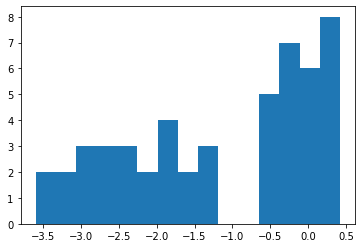

In [100]:
import matplotlib.pyplot as plt

samples = pd.read_csv("samples_1.csv").set_index("Unnamed: 0").to_numpy()

_ = plt.hist(samples, bins = 15)

Inference - MCMC

Priors:
- mean: Normal(0, 10)
- Sigma: Gamma(1,1)

sample mean tf.Tensor([43.329178 32.873905 -8.215626 -5.177249], shape=(4,), dtype=float32)
sample standard deviation tf.Tensor([10.43069   11.144204   3.790887   3.9169457], shape=(4,), dtype=float32)


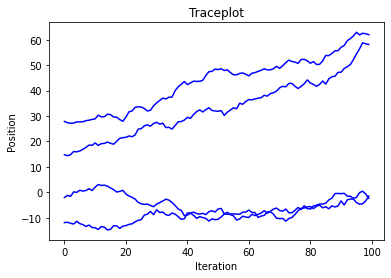

In [109]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import math

tfd = tfp.distributions
dtype = np.float32
data = pd.read_csv("samples_1.csv").set_index("Unnamed: 0").to_numpy()


def target_log_prob(param):
    mu_1, mu_2, sigma_1, sigma_2 = param
    dens = mu_1 + mu_2
    # dens = tf.math.reduce_sum(tf.math.log(
    #     1/(3*tf.math.sqrt(2*math.pi*sigma_1**2)) * tf.math.exp(-0.5*(data - mu_1)**2/sigma_1**2) + 
    #     1/(3*tf.math.sqrt(2*math.pi*sigma_2**2)) * tf.math.exp(-0.5*(data - mu_2)**2/sigma_2**2)) -
    #     1/3 * (mu_1**2 + mu_2**2) - 
    #     (sigma_1**2 + sigma_2**2))
    return(dens)

# Define MALA sampler with `step_size` equal to 0.75
samples = tfp.mcmc.sample_chain(
    num_results=100,
    current_state=dtype([1, 1, 1, 1]),
    kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=target_log_prob,
        step_size=0.75),
    num_burnin_steps=50,
    trace_fn=None,
    seed=42)

sample_mean = tf.reduce_mean(samples, axis=0)
sample_std = tf.sqrt(
    tf.reduce_mean(
        tf.math.squared_difference(samples, sample_mean),
        axis=0))

print('sample mean', sample_mean)
print('sample standard deviation', sample_std)

plt.title('Traceplot')
plt.plot(samples.numpy(), 'b')
plt.xlabel('Iteration')
plt.ylabel('Position')
plt.show()
